<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Building-&amp;-training-the-model" data-toc-modified-id="Building-&amp;-training-the-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Building &amp; training the model</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#View-Results" data-toc-modified-id="View-Results-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>View Results</a></span></li><li><span><a href="#Notes-&amp;-Work" data-toc-modified-id="Notes-&amp;-Work-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Notes &amp; Work</a></span><ul class="toc-item"><li><span><a href="#Loss-Notes" data-toc-modified-id="Loss-Notes-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Loss Notes</a></span></li><li><span><a href="#Loss-Work" data-toc-modified-id="Loss-Work-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Loss Work</a></span></li></ul></li></ul></li></ul></div>

# Building & training the model

## Data

In [ ]:
from fastai.vision.all import *


### Params ###
im_size      = 224
batch_size   = 64
path         = Path('/home/rory/data/coco2017')
valid_split  = .15


### Load data (singles) ###
# Grab cols
def grab_cols(df, cols):
    """Expects: DataFrame df; str or list of strs cols. Returns: L or an LoL."""
    def _grab_col(df, col):
        return L((ColReader(col)(df)).to_list())
    
    if isinstance(cols, str): return _grab_col(df, cols)
    if len(cols)==1: return _grab_col(df, cols)
    if len(cols)>=2:
        r=L()
        for c in cols:
            r.append(_grab_col(df,c))
        return r
df = pd.read_pickle(path/'singles.pkl')
imp, lbl, bbox = grab_cols(df, ['im','lbl','bbox'])
bbox = bbox.map(lambda x:list(x)) # fixed pickle bug; lists incorrectly unpickled as tups
# Create getters for pipeline
imp2lbl  = {p:l for p,l in zip(imp,lbl)}
imp2bbox = {p:b for p,b in zip(imp,bbox)}
def get_lbl(p):  return imp2lbl[p]
def get_bbox(p): return imp2bbox[p]


### Datasets ###
dss_tfms = [[PILImage.create],
            [get_bbox, TensorBBox.create],
            [get_lbl, Categorize()]]
splits = RandomSplitter(valid_split)(imp)
dss = Datasets(imp, tfms=dss_tfms, splits=splits)


### DataLoaders ###
cpu_tfms = [BBoxLabeler(), PointScaler(),
            Resize(im_size, method=ResizeMethod.Squish), ToTensor()]
gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
dls = dss.dataloaders(bs=batch_size, after_item=cpu_tfms, after_batch=gpu_tfms)
dls.n_inp = 1

## Model

In [ ]:
### Model ###
class custom_module(Module):
    def __init__(self, body, head):
        self.body, self.head = body, head

    def forward(self, x):
        return self.head(self.body(x)) 
body = create_body(resnet34, pretrained=True)
head = create_head(1024, 4+dss.c, ps=0.5)
mod  = custom_module(body, head)


### Loss ###
# make this a class that finds alpha, beta, and gamma on init
def lbb_loss(pred, targ_bb, targ_lbl):
    mse = MSELossFlat()(pred[:,:4], torch.squeeze(targ_bb))
    cel = CrossEntropyLossFlat()(pred[:,4:], targ_lbl)
    alpha, beta, gamma = 1,10,1
    return mse*alpha + cel*beta*gamma

In [ ]:
### Metrics ###
# See https://github.com/fastai/fastai/blob/715c027b0ad8586feda09e29fb2b483dfe30c910/fastai/learner.py#L344
# class Met(Metric):
#     @property
#     def value(self): return 1
    
# def lbb_acc(inp, targ, axis=-1):
#     pred,targ = flatten_check(inp[:,4:].argmax(dim=axis), targ)
#     return (pred == targ).float().mean()

## Train

0.0005248074419796466

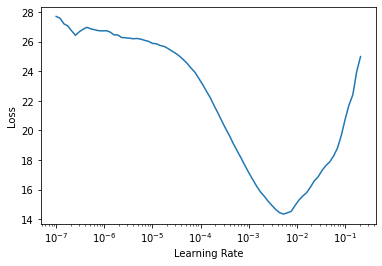

In [ ]:
learner = Learner(dls, mod, loss_func=lbb_loss)
lr_min, _ = learner.lr_find(); lr_min

Learning rates:
- mse only: 1e-2
- cel only: 5e-4
- combined: 5e-4

Min loss achieved after 8 epochs: 1.881

In [ ]:
learner.fit_one_cycle(8, lr=5e-4) # mse only: lr=1e-2 ; cel only: lr=5e-4 ; both: 5e-4

epoch,train_loss,valid_loss,time
0,4.360219,5.940746,00:14
1,4.658722,13.928998,00:14
2,4.026545,3.680221,00:14
3,3.008125,4.767646,00:14
4,1.671132,2.884153,00:14
5,0.845504,2.575560,00:14
6,0.396351,1.894666,00:14
7,0.239645,1.881281,00:14


## View Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

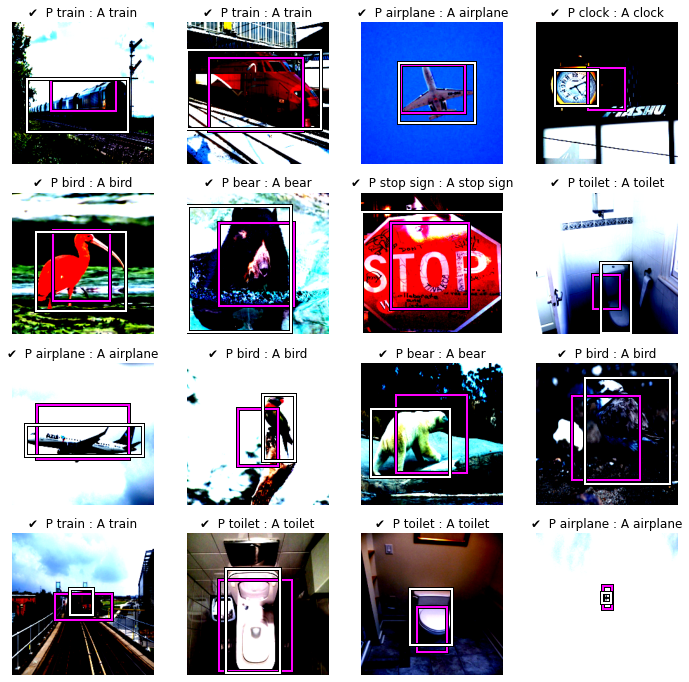

In [ ]:
### View Results ###
# get preds
ib,bb,lb = dls.one_batch()
preds = learner.model(ib)
pred_bbs = preds[:,:4]
pred_lbls = preds[:,4:].argmax(dim=-1)

# show n preds
n=16
nrows=4
ncols=4
start_idx=0

ctxs = get_grid(n, nrows, ncols)
for i,ctx in enumerate(ctxs):
    idx = start_idx+i
    # title
    pred_title=dls.vocab[pred_lbls[idx].item()]
    act_title=dls.vocab[lb[idx].item()]
    got_it='✔️' if pred_title==act_title else '✖️'
    title=f"{got_it}  P {pred_title} : A {act_title}"
    # im
    show_image(ib[idx], ctx=ctx, title=title)
    # bbs
    pred_bb = TensorBBox(pred_bbs[idx])
    targ_bb = TensorBBox(bb[idx])
    ((pred_bb+1)*224//2).show(ctx=ctx, color='magenta')
    ((targ_bb+1)*224//2).show(ctx=ctx);

## Notes & Work

### Loss Notes

My notes from my journal
1. `xb,yb = b`
2. `p = mod(xb)`
3. `alpha = cel(mb) / rmse(mb); beta = 1`
4. `if epoch <= 3: gamma=10; else: gamma=1` (do later)
5. `loss(p, yb): rmse(p[0:4],yb[0])*alpha*gamma + cel(p[4:],yb[1])*beta`

Method chain for learning (from https://github.com/fastai/fastai/blob/master/fastai/learner.py#L163)
1. `learner.fit_one_cycle()`
2. → `.fit()`
3. → `._do_fit()`
4. → `._do_epoch()`
5. → `._do_epoch_train(); ._do_epoch_validate()` (rest of chain follows `_do_epoch_train`)
6. → `.dl = .dls.train; .all_batches()`
7. → `.n_iter = len(.dl); for o in enum(.dl): .one_batch(*o)` o=(i,b)
8. → `.iter = i; ._split(b); ._do_one_batch()` (item 9 has `_split`, item 10 has `_do_one_batch`)
9. → `._split(b)`: `i = dls.n_inp; .xb, .yb = b[:i], b[i:]`
10. → `._do_one_batch()`:
    - `.pred = .model(*xb)`
    - `.loss = .loss_func(.pred, *.yb)`
    - `._backward()` → `.loss.backward()`
    - `._step()` → `.opt.step()`
    - `.opt.zero_grad()`

### Loss Work

In [ ]:
learner = Learner(dls, mod, loss_func=lbb_loss)
learner.dl = learner.dls.train
learner.b  = learner.dl.one_batch()
learner._split(learner.b)

In [ ]:
learner.pred = learner.model(learner.xb[0])

In [ ]:
learner.pred.shape

torch.Size([64, 12])

In [ ]:
learner.pred[0]

tensor([-0.1258,  0.3672,  0.5901, -0.1777, -0.8904,  0.7933,  0.2428,  1.9469,
        -0.5976, -1.0789, -1.2176, -0.4324], device='cuda:0',
       grad_fn=<SelectBackward>)

In [ ]:
learner.yb[0].shape

torch.Size([64, 1, 4])

In [ ]:
[learner.yb[0].shape[0], learner.yb[0].shape[-1]]

[64, 4]

In [ ]:
learner.yb

(TensorBBox([[[-0.2176, -0.0629, -0.0134,  0.2128]],
 
         [[-0.2596, -0.8973,  0.3544,  0.9628]],
 
         [[-1.0000, -0.3716,  0.9917,  0.3761]],
 
         [[-0.6538, -0.5697,  0.7310,  0.8563]],
 
         [[-0.4638, -0.3515,  0.3256,  0.1168]],
 
         [[-0.5657, -0.4710,  0.0906, -0.0882]],
 
         [[-0.0990, -0.6553,  0.4875, -0.2109]],
 
         [[-0.9313, -0.3214,  0.9131,  0.4786]],
 
         [[-0.4485,  0.0178, -0.3423,  0.2311]],
 
         [[-0.7116, -0.4122,  0.3024,  0.3671]],
 
         [[-0.5355, -0.5242,  0.4081,  0.5527]],
 
         [[-0.9284, -0.5109,  0.9340,  0.4554]],
 
         [[-0.4018, -0.4036,  0.5217,  0.4458]],
 
         [[-0.7367,  0.0744, -0.5844,  0.2837]],
 
         [[-1.0000, -0.9713,  0.8297,  1.0000]],
 
         [[-0.3388, -0.6430, -0.1341, -0.5146]],
 
         [[-0.9924, -0.1374,  0.7230,  0.3086]],
 
         [[-0.7736,  0.4367, -0.0809,  1.0000]],
 
         [[-0.0785, -0.4619,  0.7832,  0.2556]],
 
         [[-0.8504, -0.8671

In [ ]:
learner.pred[:,4:].shape

torch.Size([64, 8])

In [ ]:
(learner.pred[:,4:]).argmax(dim=-1)

tensor([3, 4, 0, 5, 1, 0, 5, 0, 7, 1, 0, 0, 7, 5, 6, 3, 7, 6, 1, 1, 1, 0, 0, 0,
        0, 5, 3, 7, 6, 0, 6, 2, 3, 1, 1, 0, 3, 3, 0, 0, 7, 3, 3, 1, 6, 6, 5, 0,
        3, 4, 2, 6, 0, 0, 6, 0, 5, 1, 4, 0, 0, 1, 5, 3], device='cuda:0')

In [ ]:
torch.squeeze(learner.yb[0]).shape

torch.Size([64, 4])

In [ ]:
learner.metrics

(#0) []

In [ ]:
def cel_loss(pred, targ_bb, targ_lbl):
#     mse = MSELossFlat()(pred[:,:4], torch.squeeze(targ_bb))
    cel = CrossEntropyLossFlat()(pred[:,4:], targ_lbl)
    return cel

In [ ]:
lbb_loss(learner.pred, learner.yb[0], learner.yb[1])

tensor(2.0821, device='cuda:0', grad_fn=<NllLossBackward>)